
![](https://ga-dash.s3.amazonaws.com/production/assets/logo-9f88ae6c9c3871690e33280fcf557f33.png)
## Project 4: Web Scraping Job Postings
#### NoteBook 3 - Part1 and Part2
## Submitted by Roshan Lulu

## Part 1: Factors that impact salary

To predict salary you will be building either a classification or regression model, using features like the location, title, and summary of the job. If framing this as a regression problem, you will be estimating the listed salary amounts. You may instead choose to frame this as a classification problem, in which case you will create labels from these salaries (high vs. low salary, for example) according to thresholds such as the median salary.

You have learned a variety of new skills and models that may be useful for this problem:
- NLP
- Unsupervised learning and dimensionality reduction techniques (PCA, clustering)
- Ensemble methods and decision tree models
- SVM models

Whatever you decide to use, the most important thing is to justify your choices and interpret your results. Communication of your process is key.

Note that most listings *DO NOT* come with salary information. Being to able extrapolate or predict the expected salaries for other listings is exactly why this model will be so valuable.

**Steps for Part 1:**

1. Collect data from [Indeed.com](www.indeed.com) (or another aggregator) on data-related jobs to use in predicting salary trends for your analysis.
  - Select and parse data from at least 1000 postings for jobs, potentially from multiple location searches.
2. Find out what factors most directly impact salaries (Title, location, department, etc.).
  - Test, validate, and describe your models. What factors predict salary category? How do your models perform?
3. Discover which features have the greatest importance when determining a low vs. high paying job.
  - Your Boss is interested in what overall features hold the greatest significance.
  - HR is interested in which SKILLS and KEY WORDS hold the greatest significance.  
4. Author a report to your Principal detailing your analysis.

### Part 0: Read in cleaned dataframe to proceed with questions 1 and 2

In [157]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

In [158]:
import re

In [159]:
import warnings
warnings.filterwarnings('ignore')

#### Read the data

In [160]:
# Savecleaned dataframe to a csv file
all_jobpost = './database/all_jobpost_cleaned_data.csv'
valid_salary_jobpost = './database/valid_jobpost_cleaned_data.csv'
valid_salary_jobpost_text = './database/valid_jobpost_text_cleaned_data.csv'

In [161]:
# Read in all the job posts with and without Salary
data = pd.read_csv(all_jobpost)
# Read in all the job posts with a valid Salary(salary != 0)
data_valid_y = pd.read_csv(valid_salary_jobpost)
# Read in job posts with valid salary and the text frame passed through count vectorizer
data_w_text = pd.read_csv(valid_salary_jobpost_text)

In [162]:
# Checking the data frame is still intact when saved to a csv and read in!

In [163]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2830 entries, 0 to 2829
Data columns (total 9 columns):
Title_Code       2830 non-null int64
City_Code        2830 non-null int64
Region_Code      2830 non-null int64
Classif_Code     2830 non-null int64
WorkType_Code    2830 non-null int64
Adv_Code         2830 non-null int64
KeyJob_Code      2830 non-null int64
JobDescript      2785 non-null object
Salary           2830 non-null float64
dtypes: float64(1), int64(7), object(1)
memory usage: 199.1+ KB


In [164]:
#### The empty string seem to have been read in as null values ~45 of them
#### I will drop them for now

In [165]:
data.dropna(subset = ['JobDescript'], axis = 0, inplace = True)
data.reset_index(drop=True, inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2785 entries, 0 to 2784
Data columns (total 9 columns):
Title_Code       2785 non-null int64
City_Code        2785 non-null int64
Region_Code      2785 non-null int64
Classif_Code     2785 non-null int64
WorkType_Code    2785 non-null int64
Adv_Code         2785 non-null int64
KeyJob_Code      2785 non-null int64
JobDescript      2785 non-null object
Salary           2785 non-null float64
dtypes: float64(1), int64(7), object(1)
memory usage: 195.9+ KB


In [166]:
data_valid_y.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 724 entries, 0 to 723
Data columns (total 9 columns):
Title_Code       724 non-null int64
City_Code        724 non-null int64
Region_Code      724 non-null int64
Classif_Code     724 non-null int64
WorkType_Code    724 non-null int64
Adv_Code         724 non-null int64
KeyJob_Code      724 non-null int64
JobDescript      719 non-null object
Salary           724 non-null float64
dtypes: float64(1), int64(7), object(1)
memory usage: 51.0+ KB


In [167]:
data_valid_y.dropna(subset = ['JobDescript'], axis = 0, inplace = True)
data_valid_y.reset_index(drop=True, inplace=True)
data_valid_y.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 719 entries, 0 to 718
Data columns (total 9 columns):
Title_Code       719 non-null int64
City_Code        719 non-null int64
Region_Code      719 non-null int64
Classif_Code     719 non-null int64
WorkType_Code    719 non-null int64
Adv_Code         719 non-null int64
KeyJob_Code      719 non-null int64
JobDescript      719 non-null object
Salary           719 non-null float64
dtypes: float64(1), int64(7), object(1)
memory usage: 50.6+ KB


In [168]:
data_w_text.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 724 entries, 0 to 723
Columns: 1009 entries, Title_Code to years experience
dtypes: float64(1), int64(1007), object(1)
memory usage: 5.6+ MB


## Qn: Factors that impact Salary
Find out what factors most directly impact salaries (Title, location, department, etc.).
    - Test, validate, and describe your models. What factors predict salary category? How do your models perform?



### Approach :
Salary is a continuous variable. Hence, I choose a regression model. The no of valid salaries are a small proportion. So I choose to take a small training set. [ The text for the training set will be used to create the word gram dataframe] The testing sets will be dependant ont he training set. The word dimensions will be a lot, so I guess using PCA might be helpful to reduce the dimensions. How can I use ensemble/SVM/Decision Tree models? 

In [169]:
from sklearn.linear_model import LinearRegression
from sklearn.cross_validation import cross_val_score
from sklearn.cross_validation import cross_val_predict
# Initialize the StandardScaler object
from sklearn.preprocessing import StandardScaler

# Trying on K-fold cross validation model
from sklearn.cross_validation import cross_val_score, cross_val_predict
from sklearn import metrics

In [170]:
seek_data = data_valid_y
seek_data.columns

Index(['Title_Code', 'City_Code', 'Region_Code', 'Classif_Code',
       'WorkType_Code', 'Adv_Code', 'KeyJob_Code', 'JobDescript', 'Salary'],
      dtype='object')

In [171]:
predictors_target = ['Title_Code', 'Region_Code', 'Classif_Code',
       'WorkType_Code', 'Adv_Code', 'KeyJob_Code', 'Salary']
seek_data = seek_data[predictors_target]

In [172]:
seek_data.shape

(719, 7)

#### My predictors are mostly categorical variables. I need convert them to dummy variables

In [173]:
target = ['Salary']
predictors = ['Title_Code', 'Region_Code', 'Classif_Code',
       'WorkType_Code', 'Adv_Code', 'KeyJob_Code']

seek_data.head()

,Title_Code,Region_Code,Classif_Code,WorkType_Code,Adv_Code,KeyJob_Code,Salary
0,5,0,0,0,0,1,180000.0
1,0,6,3,0,2,1,90000.0
2,1,6,0,0,0,1,14400.0
3,1,0,7,0,2,1,120000.0
4,1,0,1,0,2,1,160000.0


In [174]:
# Convert the categorical variables to dummies to proceed with linear regression
seek_data_dummies = pd.get_dummies(seek_data, drop_first = True, columns = ['Title_Code', 'Region_Code', 'Classif_Code',
       'WorkType_Code', 'Adv_Code', 'KeyJob_Code'])

In [175]:
# train_data.drop('level_0')
seek_data_dummies.head()

,Salary,Title_Code_1,Title_Code_2,Title_Code_3,Title_Code_4,Title_Code_5,Title_Code_6,Title_Code_7,Region_Code_1,Region_Code_2,Region_Code_3,Region_Code_4,Region_Code_5,Region_Code_6,Region_Code_7,Region_Code_8,Region_Code_9,Region_Code_10,Region_Code_12,Region_Code_13,Region_Code_14,Region_Code_16,Region_Code_18,Classif_Code_1,Classif_Code_2,Classif_Code_3,Classif_Code_4,Classif_Code_5,Classif_Code_6,Classif_Code_7,WorkType_Code_1,WorkType_Code_2,Adv_Code_1,Adv_Code_2,KeyJob_Code_1,KeyJob_Code_2,KeyJob_Code_3,KeyJob_Code_4
0,180000.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,90000.0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0
2,14400.0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3,120000.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0
4,160000.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0


### Trying to fit the model with statsmodel
- Model has an R2 of 0.839. meaning the predictors explain about 83.9% of the variance.

In [176]:
import statsmodels.api as sm
import patsy

In [177]:
# Prepare the list of Xs for the patsy formula
cols = list(seek_data_dummies.columns)
cols.remove('Salary')
all_columns = "+".join(cols)

# Prepare the patsy format y~ Xs
my_formula = "Salary~" + all_columns

y, X = patsy.dmatrices(my_formula, data=seek_data_dummies, return_type='dataframe')

y = y.values.ravel()

model = sm.OLS(y, X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.243
Model:                            OLS   Adj. R-squared:                  0.202
Method:                 Least Squares   F-statistic:                     5.908
Date:                Fri, 12 May 2017   Prob (F-statistic):           3.14e-23
Time:                        06:19:38   Log-Likelihood:                -8729.4
No. Observations:                 719   AIC:                         1.753e+04
Df Residuals:                     681   BIC:                         1.771e+04
Df Model:                          37                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept        8.428e+04   1.34e+04      6.307      0.000     5.8e+04    1.11e+05
Title_Code_1     3.096e+04   1.21e+04      2.551      0.011    7128.006    5.48e+04
Title_Code_2     5.219e+04   1.27e+04      4.117      0.000    2.73e+04    7.71e+04
Title_Code_3     4.018e+04   1.37e+04      2.935      0.003    1.33e+04    6.71e+04
Title_Code_4     5.454e+04   1.63e+04      3.338      0.001    2.25e+04    8.66e+04
Title_Code_5     6.419e+04   1.34e+04      4.774      0.000    3.78e+04    9.06e+04
Title_Code_6     9.594e+04   4.89e+04      1.960      0.050    -147.121    1.92e+05
Title_Code_7     8.011e+04   1.62e+04      4.941      0.000    4.83e+04    1.12e+05
Region_Code_1    4976.9407   8256.536      0.603      0.547   -1.12e+04    2.12e+04
Region_Code_2     239.5901   1.04e+04      0.023      0.982   -2.02e+04    2.07e+04
Region_Code_3   -1.016e+04   9856.237     -1.031      0.303   -2.95e+04    9190.582
Region_Code_4   -3.154e+04    1.4e+04     -2.256      0.024    -5.9e+04   -4095.629
Region_Code_5   -3.773e+04   3.36e+04     -1.124      0.262   -1.04e+05    2.82e+04
Region_Code_6   -2114.1112   8336.825     -0.254      0.800   -1.85e+04    1.43e+04
Region_Code_7   -1.578e+04   4955.781     -3.185      0.002   -2.55e+04   -6054.116
Region_Code_8   -2.682e+04   1.42e+04     -1.887      0.060   -5.47e+04    1089.770
Region_Code_9   -7.178e+04   2.23e+04     -3.213      0.001   -1.16e+05   -2.79e+04
Region_Code_10  -4.549e+04   2.85e+04     -1.598      0.111   -1.01e+05    1.04e+04
Region_Code_12   1684.8711   1.06e+04      0.159      0.874   -1.91e+04    2.25e+04
Region_Code_13   -2.23e+04   7299.165     -3.056      0.002   -3.66e+04   -7972.160
Region_Code_14  -2.652e+04   3.34e+04     -0.793      0.428   -9.22e+04    3.91e+04
Region_Code_16  -7.699e+04   4.69e+04     -1.641      0.101   -1.69e+05    1.51e+04
Region_Code_18  -2.199e+04   1.71e+04     -1.286      0.199   -5.56e+04    1.16e+04
Classif_Code_1  -1264.9484   1.34e+04     -0.095      0.925   -2.75e+04     2.5e+04
Classif_Code_2  -8243.5486   5262.123     -1.567      0.118   -1.86e+04    2088.386
Classif_Code_3  -7737.1685   8445.390     -0.916      0.360   -2.43e+04    8844.963
Classif_Code_4  -2.943e+04   9453.384     -3.113      0.002    -4.8e+04   -1.09e+04
Classif_Code_5  -2.239e+04   1.92e+04     -1.167      0.243   -6.01e+04    1.53e+04
Classif_Code_6  -2.808e+04   2.89e+04     -0.971      0.332   -8.49e+04    2.87e+04
Classif_Code_7   -1.69e+04   7131.880     -2.369      0.018   -3.09e+04   -2892.181
WorkType_Code_1  3.571e+04   4030.317      8.859      0.000    2.78e+04    4.36e+04
WorkType_Code_2  7255.8499   2.44e+04      0.297      0.766   -4.07e+04    5.52e+04
Adv_Code_1       8223.7326   1.73e+04      0.475      0.635   -2.58e+04    4.22e+04
Adv_Code_2       1929.9104   4779.219      0.404      0.686

#### Split the data --> 40/60 Test/Train Split 

In [178]:
cols = list(seek_data_dummies.columns)
cols.remove('Salary')
X = seek_data_dummies[cols]
y = seek_data_dummies['Salary']

In [179]:
from sklearn.model_selection import train_test_split

In [180]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4)
print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)

(431, 37) (431,)
(288, 37) (288,)


#### Fitting with Linear Regression Model 

In [181]:
from sklearn.linear_model import LinearRegression

slr = LinearRegression()
slr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [182]:
print (slr.score(X_train, y_train))

0.243253031768


In [183]:
print (slr.score(X_test, y_test))

0.189304339605


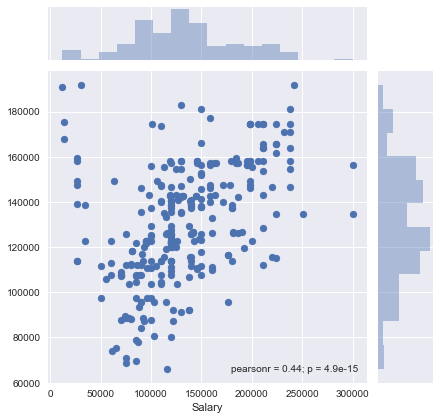

In [184]:
yhat = slr.predict(X_test)
sns.jointplot(y_test, yhat)
plt.show()

### Fitting with Linear Regression Model using K-fold Cross validation

In [185]:
from sklearn.cross_validation import cross_val_score, cross_val_predict
from sklearn import metrics

# Perform 5-fold cross validation
scores = cross_val_score(slr, X, y, cv=5)
print ("Cross-validated scores:", scores)

# Make cross validated predictions on the test sets
predictions = cross_val_predict(slr, X, y, cv=5)
plt.scatter(y, predictions)

# manually calcualte the r2
r2 = metrics.r2_score(y, predictions)
print ("Cross-Predicted R2:", r2)


Cross-validated scores: [ 0.05679801 -0.02606591  0.18541915  0.11939345 -0.08365894]
Cross-Predicted R2: 0.0853879185835


#### That is a pretty bad score for the Linear regression model using all the features. 
# Residul Chech woul dbe good
#### Let me try some regularization methods to find better predictors
    - Before any regularization, Standardize predictors! 

In [186]:
from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression, RidgeCV, LassoCV, ElasticNetCV

In [187]:
cols = list(seek_data_dummies.columns)
cols.remove('Salary')
X = seek_data_dummies[cols]
y = seek_data_dummies['Salary']

In [188]:
# Initialize the StandardScaler object
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()

# use the "fit_transform" function to standardize the X design matrix
Xs = ss.fit_transform(X)

In [189]:
linreg = LinearRegression()

linreg_scores = cross_val_score(linreg, Xs, y, cv=10)

print(linreg_scores)
print(np.mean(linreg_scores))

[ -1.57211942e+23   2.24421834e-01   1.40781607e-01   1.09145718e-01
   2.31998114e-01   1.71435414e-01   1.90889020e-01   8.16590119e-02
  -9.44318567e-02  -2.68758897e-01]
-1.57211941582e+22


#### R2 is negative for the Linear regression model with all Xs as predictors. That is obviously not a good one.

#### Ridge and its visualization

In [190]:
ridge_alphas = np.logspace(0, 5, 200)

optimal_ridge = RidgeCV(alphas=ridge_alphas, cv=10)
optimal_ridge.fit(Xs, y)

print(optimal_ridge.alpha_)

193.389175046


In [191]:
ridge = Ridge(alpha=optimal_ridge.alpha_)

ridge_scores = cross_val_score(ridge, Xs, y, cv=10)

print (ridge_scores)
print (np.mean(ridge_scores))

[ 0.01748228  0.19975335  0.1421944   0.11437012  0.21247055  0.17218376
  0.1771798   0.08719441  0.11462226 -0.10153343]
0.113591750236


#### The ridge scores are better than the linear regression, but its not good enough

#### Lasso and its visualization

In [192]:
optimal_lasso = LassoCV(n_alphas=500, cv=10, verbose=1)
optimal_lasso.fit(Xs, y)

print (optimal_lasso.alpha_)

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

1175.97452923


...........................................................................................................................................................................................................................................................................................................................[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    1.1s finished


#### Cross validating lasso R2 with optimal alpha

In [193]:
lasso = Lasso(alpha=optimal_lasso.alpha_)

lasso_scores = cross_val_score(lasso, Xs, y, cv=10)

print (lasso_scores)
print (np.mean(lasso_scores))

[ 0.01810071  0.19908461  0.1471569   0.07849835  0.23136643  0.18439633
  0.20566381  0.09748666  0.0574874  -0.17325028]
0.104599091138


In [194]:
lasso.fit(Xs, y)

Lasso(alpha=1175.9745292330354, copy_X=True, fit_intercept=True,
   max_iter=1000, normalize=False, positive=False, precompute=False,
   random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

In [195]:
lasso_coefs = pd.DataFrame({'variable':X.columns,
                            'coef':lasso.coef_,
                            'abs_coef':np.abs(lasso.coef_)})

lasso_coefs.sort_values('abs_coef', inplace=True, ascending=False)

lasso_best = list(lasso_coefs.variable.head().values)
lasso_coefs

,abs_coef,coef,variable
29,15994.847910,15994.847910,WorkType_Code_1
4,5315.509015,5315.509015,Title_Code_5
6,4722.332982,4722.332982,Title_Code_7
15,4451.997566,-4451.997566,Region_Code_9
13,4238.437645,-4238.437645,Region_Code_7
25,3905.667372,-3905.667372,Classif_Code_4
0,3583.228225,-3583.228225,Title_Code_1
1,3512.281199,3512.281199,Title_Code_2
18,3452.972360,-3452.972360,Region_Code_13
10,2962.291577,-2962.291577,Region_Code_4


In [196]:
print ('Percent variables zeroed out:', np.sum((lasso.coef_ == 0))/float(X.shape[0]))

Percent variables zeroed out: 0.0152990264256


#### R2 doesnt improve much using Lasso. Still ~0.1 :(

#### Elastic net and its visualization

In [197]:
l1_ratios = np.linspace(0.01, 1.0, 25)

optimal_enet = ElasticNetCV(l1_ratio=l1_ratios, n_alphas=100, cv=10,
                            verbose=1)
optimal_enet.fit(Xs, y)

print (optimal_enet.alpha_)
print (optimal_enet.l1_ratio_)

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

1200.06122929
1.0


..............................................................................................................................................................................................................[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    4.6s finished


In [198]:
enet = ElasticNet(alpha=optimal_enet.alpha_, l1_ratio=optimal_enet.l1_ratio_)

enet_scores = cross_val_score(enet, Xs, y, cv=10)

print (enet_scores)
print (np.mean(enet_scores))

[ 0.01781264  0.19781893  0.14721716  0.07714601  0.23088773  0.18426346
  0.20532304  0.09692192  0.06028887 -0.17136761]
0.104631214709


#### Again no change in R2.

### In the search for a better performing model, next I'm going to try Feature selection methods

In [199]:
from sklearn.feature_selection import SelectKBest, chi2, f_classif

# build the selector (we'll build one with each score type)
skb_f = SelectKBest(f_classif, k=5)
skb_chi2 = SelectKBest(chi2, k=5)

# train the selector on our data
skb_f.fit(X, y)
# skb_chi2.fit(X, y)

# examine results
kbest = pd.DataFrame([cols, list(skb_f.scores_)], 
                     index=['feature','f_classif']).T.sort_values('f_classif', ascending=False)
kbest.head()

,feature,f_classif
31,Adv_Code_1,inf
6,Title_Code_7,16.1257
29,WorkType_Code_1,14.9747
30,WorkType_Code_2,12.4037
26,Classif_Code_5,9.03016


In [200]:
kbest_features = list(kbest.feature.head(4).values)
(kbest_features)

['Adv_Code_1', 'Title_Code_7', 'WorkType_Code_1', 'WorkType_Code_2']

In [201]:
X_kbest = seek_data_dummies[kbest_features]
X_lasso = seek_data_dummies[lasso_best]
y = seek_data_dummies['Salary']

In [202]:
# Initialize the StandardScaler object
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()

# use the "fit_transform" function to standardize the X design matrix
Xs_kbest = ss.fit_transform(X_kbest)
Xs_lasso = ss.fit_transform(X_lasso)

In [203]:

linreg = LinearRegression()

linreg_scores_kbest = cross_val_score(linreg, Xs_kbest, y, cv=10)
linreg_scores_lasso = cross_val_score(linreg, Xs_lasso, y, cv=10)

print('Kbest Scores')
print(linreg_scores_kbest)
print(np.mean(linreg_scores_kbest))

print('Lasso Scores')
print(linreg_scores_lasso)
print(np.mean(linreg_scores_lasso))

Kbest Scores
[-0.02766586  0.03155965  0.10802576  0.07781796  0.19053899  0.14784653
  0.10887081  0.04190342  0.0995485  -0.29547451]
0.0482971230279
Lasso Scores
[ 0.0345942   0.19476983  0.0892964  -0.00692417  0.19735855  0.14111909
  0.18878691  0.12255158  0.0738892  -0.09536727]
0.0940074312282


#### The scores are not getting any better !

### Checking gradient Descent assessor to minimize the loss function

In [204]:
from sklearn.linear_model import SGDRegressor, SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.grid_search import GridSearchCV

In [205]:
# Prepare the list of Xs for the patsy formula
cols = list(seek_data_dummies.columns)
cols.remove('Salary')
all_columns = "+".join(cols)

X = patsy.dmatrix(all_columns, data=seek_data_dummies, return_type='dataframe')

y = seek_data_dummies.Salary.values
ss = StandardScaler()
Xs = ss.fit_transform(X)
print (y.shape, Xs.shape)

(719,) (719, 38)


In [206]:
# set up my gridsearch parameters:
sgd_params = {
    'loss':['squared_loss','huber'],
    'penalty':['l1','l2','elasticnet'],
    'alpha':np.logspace(-5,1,25)
}

sgd_reg = SGDRegressor()
sgd_reg_gs = GridSearchCV(sgd_reg, sgd_params, cv=5, verbose=1)

In [207]:
# SGD is pretty fast compared to other sklearn solvers - but can still
# take a good long while depending on the gridsearch and the size of
# the dataset.
sgd_reg_gs.fit(Xs, y)

Fitting 5 folds for each of 150 candidates, totalling 750 fits


[Parallel(n_jobs=1)]: Done 750 out of 750 | elapsed:    1.8s finished


GridSearchCV(cv=5, error_score='raise',
       estimator=SGDRegressor(alpha=0.0001, average=False, epsilon=0.1, eta0=0.01,
       fit_intercept=True, l1_ratio=0.15, learning_rate='invscaling',
       loss='squared_loss', n_iter=5, penalty='l2', power_t=0.25,
       random_state=None, shuffle=True, verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'loss': ['squared_loss', 'huber'], 'penalty': ['l1', 'l2', 'elasticnet'], 'alpha': array([  1.00000e-05,   1.77828e-05,   3.16228e-05,   5.62341e-05,
         1.00000e-04,   1.77828e-04,   3.16228e-04,   5.62341e-04,
         1.00000e-03,   1.77828e-03,   3.16228e-03,   5.62341e-03,
    ...2341e-01,
         1.00000e+00,   1.77828e+00,   3.16228e+00,   5.62341e+00,
         1.00000e+01])},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=1)

In [208]:
print (sgd_reg_gs.best_params_)
print (sgd_reg_gs.best_score_)
sgd_reg = sgd_reg_gs.best_estimator_

{'alpha': 1.0, 'loss': 'squared_loss', 'penalty': 'elasticnet'}
0.08322302581485057


### Infer:
    - The Linear Regression is not a good model for predicting the salary. It could coz of the less valid salaries that were available.
    - How to make the model better:
        - Try vectorizing the words and add them as features. 
        - Get more valid salary data

### Qn.Discover which features have the greatest importance when determining a low vs. high paying job.
- Your Boss is interested in what overall features hold the greatest significance.
- HR is interested in which SKILLS and KEY WORDS hold the greatest significance.  

### Approach
    - In order to get the overall features/SKILLS/Keywords that are significant, the target is not the continuous salary anymore.
    - Add a new target that will be 0/1 based on low paying vs high paying jobs!
    - This now becomes a classification problem.
    - What features are good to determine the new target low/high pay jobs!
    - Can I use CARTS/ KNN / LogisticRegressionCV/PCA
    - words that are significant to determine low/high pay jobs
    - Can I use PCA on all the keywords and skills?

In [209]:
# Copy the dataframe
class_data = data_valid_y
class_data
#pick the feature columns
predictors = ['Title_Code', 'Region_Code', 'Classif_Code',
       'WorkType_Code', 'KeyJob_Code']
# Target is salary range. Currently Salary is a continuous variable. 
# Create the target feature to make Salary high/low or 1/0 paying jobs
class_data = class_data[['Title_Code', 'Region_Code', 'Classif_Code',
       'WorkType_Code', 'KeyJob_Code', 'Salary']]

#### Assumption: Salary > 120,000 per annum - High paying job
    - With the data I have, 120000 looks like the median. I chose this for better segregation of results

In [210]:
# Convert salary to a new feature
class_data['High_Pay'] = [1 if salary > 110000 else 0 for salary in class_data['Salary']]
# Check Distribution of Salary to find the median
print(class_data['High_Pay'].value_counts())

1    444
0    275
Name: High_Pay, dtype: int64


In [211]:
# Convert the categorical variables to dummies to proceed with linear regression
class_data_dummies = pd.get_dummies(class_data, drop_first = True, columns = ['Title_Code', 'Region_Code', 'Classif_Code',
       'WorkType_Code', 'KeyJob_Code'])

In [212]:
class_data_dummies.columns

Index(['Salary', 'High_Pay', 'Title_Code_1', 'Title_Code_2', 'Title_Code_3',
       'Title_Code_4', 'Title_Code_5', 'Title_Code_6', 'Title_Code_7',
       'Region_Code_1', 'Region_Code_2', 'Region_Code_3', 'Region_Code_4',
       'Region_Code_5', 'Region_Code_6', 'Region_Code_7', 'Region_Code_8',
       'Region_Code_9', 'Region_Code_10', 'Region_Code_12', 'Region_Code_13',
       'Region_Code_14', 'Region_Code_16', 'Region_Code_18', 'Classif_Code_1',
       'Classif_Code_2', 'Classif_Code_3', 'Classif_Code_4', 'Classif_Code_5',
       'Classif_Code_6', 'Classif_Code_7', 'WorkType_Code_1',
       'WorkType_Code_2', 'KeyJob_Code_1', 'KeyJob_Code_2', 'KeyJob_Code_3',
       'KeyJob_Code_4'],
      dtype='object')

In [213]:
predictors = list(class_data_dummies.columns)
predictors.remove('Salary')

In [214]:
predictors.remove('High_Pay')

In [215]:
# Create target and predictor data
X_cls = class_data_dummies[['Title_Code_1', 'Title_Code_2', 'Title_Code_3',
       'Title_Code_4', 'Title_Code_5', 'Title_Code_6', 'Title_Code_7',
       'Region_Code_1', 'Region_Code_2', 'Region_Code_3', 'Region_Code_4',
       'Region_Code_5', 'Region_Code_6', 'Region_Code_7', 'Region_Code_8',
       'Region_Code_9', 'Region_Code_10', 'Region_Code_12', 'Region_Code_13',
       'Region_Code_14', 'Region_Code_16', 'Region_Code_18', 'Classif_Code_1',
       'Classif_Code_2', 'Classif_Code_3', 'Classif_Code_4', 'Classif_Code_5',
       'Classif_Code_6', 'Classif_Code_7', 'WorkType_Code_1',
       'WorkType_Code_2', 'KeyJob_Code_1', 'KeyJob_Code_2', 'KeyJob_Code_3',
       'KeyJob_Code_4']]
y_cls = class_data_dummies['High_Pay'].values

In [216]:
# Cross validate regression and logistic regression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

In [217]:
cls_scores = cross_val_score(LogisticRegression(), X_cls, y_cls, cv=4)

print ('Classification/Logistic regression score:', cls_scores, np.mean(cls_scores))

logreg = LogisticRegression().fit(X_cls, y_cls)

Classification/Logistic regression score: [ 0.66666667  0.71111111  0.66666667  0.67039106] 0.678708876474


#### The Linear regression score is still not great. However, Classification score looks good with the data

#### The aim is to find features that contribute to identify the different classification groups. I will try using the Grid Search CV for the  Decision tree classifier

In [218]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

In [219]:
# Setting up the parameters for Gridsearch CV
dtc_params = {
    'max_depth':[None,1,2,3,4],
    'max_features':[None,'log2','sqrt',2,3,4,5],
    'min_samples_split':[2,3,4,5,10,15,20,25,30,40,50]
}

dtc_gs = GridSearchCV(DecisionTreeClassifier(), dtc_params, cv=5, verbose=1)

In [220]:
dtc_gs.fit(X_cls, y_cls)

Fitting 5 folds for each of 385 candidates, totalling 1925 fits


[Parallel(n_jobs=1)]: Done 1925 out of 1925 | elapsed:    5.7s finished


GridSearchCV(cv=5, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'max_depth': [None, 1, 2, 3, 4], 'max_features': [None, 'log2', 'sqrt', 2, 3, 4, 5], 'min_samples_split': [2, 3, 4, 5, 10, 15, 20, 25, 30, 40, 50]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=1)

In [221]:
dtc_best = dtc_gs.best_estimator_
print (dtc_gs.best_params_)
print (dtc_gs.best_score_)

{'max_depth': 2, 'max_features': None, 'min_samples_split': 2}
0.70792767733


In [222]:
# Get the features with the most importance from the GridSearch CV on the Decision Tree classifier
fi = pd.DataFrame({
        'feature':X_cls.columns,
        'importance':dtc_best.feature_importances_
    })

fi.sort_values('importance', ascending=False, inplace=True)
fi

,feature,importance
0,Title_Code_1,0.534809
29,WorkType_Code_1,0.393221
15,Region_Code_9,0.071970
25,Classif_Code_4,0.000000
20,Region_Code_16,0.000000
21,Region_Code_18,0.000000
22,Classif_Code_1,0.000000
23,Classif_Code_2,0.000000
24,Classif_Code_3,0.000000
26,Classif_Code_5,0.000000


#### Inference from Grid Search CV results:
- The Job Title_Code_1, Region_Code_9, Work_TypCode_1 are the top most important features for  determining a High vs low pay job

In [223]:
## Repeating the GridSearch CV for getting the Key skills and words from the Job description

In [224]:
# Get the dataframe with valid salary and text extracted
data_w_text.shape
# Copy the dataframe


(724, 1009)

In [225]:
class_data = data_w_text
class_data.head(2)

,Title_Code,City_Code,Region_Code,Classif_Code,WorkType_Code,Adv_Code,KeyJob_Code,JobDescript,Salary,12 months,12 months successful,13 january,13 january 2017,2010 cca,2010 cca additional,2010 regulatory,2010 regulatory instruments,2010 review,2010 review investigate,2017 months,2017 months automatically,400 words,ability work,accc aer,accc aer accc,accc aer called,accc aer functions,accc aer ii,accc aer responsibilities,accc aer seeking,accc aers,accc aers goals,accc aers work,accc gov,accc gov au,accc independent,accc independent commonwealth,accc specialist,accc specialist legal,accc supported,accc supported staff,access accc,access accc specialist,accounting related,accounting related fields,act 2010,act 2010 cca,act 2010 regulatory,act 2010 review,ad hoc,additional legislation,additional legislation promoting,additional roles,additional roles review,additionally want,additionally want build,administrative undertakings,administrative undertakings court,advanced excel,advertised externally,advertised externally 13,advice range,advice range accc,advocating policy,advocating policy changes,aer accc,aer accc independent,aer board,aer board separate,aer called,aer called fulfil,aer functions,aer functions maintain,aer ii,aer ii technically,aer independent,aer independent body,aer responsibilities,aer responsibilities apply,aer seeking,aer seeking applications,aers goals,aers goals accc,aers work,aers work rapidly,aim recruitment,aim recruitment immediately,analyse assess,analyse assess distil,analysis consumer,analysis consumer protection,analysis data,analysis experience,analyst join,analyst role,analyst work,analytical skills,anti competitive,anti competitive conduct,applicant processes,applicant processes wish,application applicant,application applicant processes,applications authorisation,applications authorisation notification,applications people,applications people skills,applied job,applied job need,applied list,applied list liketo,applied process,applied process list,apply applying,apply button,apply click,apply maybe,apply maybe selection,apply online,apply online using,apply senior,apply senior people,apply today,apply tools,apply tools available,appoint people,appoint people specialist,appropriate link,aps classifications,aps classifications people,aps executive,aps executive level,areas location,areas location considered,arise 12,arise 12 months,arrangements conduct,arrangements conduct result,asked upload,asked upload resume,assess distil,assess distil key,assessing reviewing,assessing reviewing mergers,assessment automatically,assessment automatically included,au notes,au notes employment,australian economy,australian economy currently,australians aer,australians aer independent,australians candidates,australians candidates seeking,authorisation notification,authorisation notification certain,authority role,authority role enforce,automatically applied,automatically applied process,automatically included,automatically included let,available opportunity,available opportunity applied,available resolve,available resolve matters,awareness influence,awareness influence business,based information,based information evidence,behaviour apply,behaviour apply applying,benefit australians,benefit australians aer,benefit warrant,benefit warrant exemption,best practice,big data,board separate,board separate accc,body responsible,body responsible regulating,broad range,broad range groups,build list,build list qualified,build organisational,build organisational capability,building specialist,building specialist teams,business analysis,business analyst,business analyst join,business analysts,business behaviour,business behaviour apply,business design,business development,business intelligence,business needs,business partnering,business process,business processes,business requirements,business stakeholders,business systems,business units,business users,businesses iii,businesses iii tactical,ca cpa,called fulfil,called fulfil specifi

In [226]:
drop_cols = ['City_Code', 'Adv_Code', 'JobDescript']
class_data.drop(drop_cols, inplace = True, axis = 1)

In [227]:
class_data.head(2)

,Title_Code,Region_Code,Classif_Code,WorkType_Code,KeyJob_Code,Salary,12 months,12 months successful,13 january,13 january 2017,2010 cca,2010 cca additional,2010 regulatory,2010 regulatory instruments,2010 review,2010 review investigate,2017 months,2017 months automatically,400 words,ability work,accc aer,accc aer accc,accc aer called,accc aer functions,accc aer ii,accc aer responsibilities,accc aer seeking,accc aers,accc aers goals,accc aers work,accc gov,accc gov au,accc independent,accc independent commonwealth,accc specialist,accc specialist legal,accc supported,accc supported staff,access accc,access accc specialist,accounting related,accounting related fields,act 2010,act 2010 cca,act 2010 regulatory,act 2010 review,ad hoc,additional legislation,additional legislation promoting,additional roles,additional roles review,additionally want,additionally want build,administrative undertakings,administrative undertakings court,advanced excel,advertised externally,advertised externally 13,advice range,advice range accc,advocating policy,advocating policy changes,aer accc,aer accc independent,aer board,aer board separate,aer called,aer called fulfil,aer functions,aer functions maintain,aer ii,aer ii technically,aer independent,aer independent body,aer responsibilities,aer responsibilities apply,aer seeking,aer seeking applications,aers goals,aers goals accc,aers work,aers work rapidly,aim recruitment,aim recruitment immediately,analyse assess,analyse assess distil,analysis consumer,analysis consumer protection,analysis data,analysis experience,analyst join,analyst role,analyst work,analytical skills,anti competitive,anti competitive conduct,applicant processes,applicant processes wish,application applicant,application applicant processes,applications authorisation,applications authorisation notification,applications people,applications people skills,applied job,applied job need,applied list,applied list liketo,applied process,applied process list,apply applying,apply button,apply click,apply maybe,apply maybe selection,apply online,apply online using,apply senior,apply senior people,apply today,apply tools,apply tools available,appoint people,appoint people specialist,appropriate link,aps classifications,aps classifications people,aps executive,aps executive level,areas location,areas location considered,arise 12,arise 12 months,arrangements conduct,arrangements conduct result,asked upload,asked upload resume,assess distil,assess distil key,assessing reviewing,assessing reviewing mergers,assessment automatically,assessment automatically included,au notes,au notes employment,australian economy,australian economy currently,australians aer,australians aer independent,australians candidates,australians candidates seeking,authorisation notification,authorisation notification certain,authority role,authority role enforce,automatically applied,automatically applied process,automatically included,automatically included let,available opportunity,available opportunity applied,available resolve,available resolve matters,awareness influence,awareness influence business,based information,based information evidence,behaviour apply,behaviour apply applying,benefit australians,benefit australians aer,benefit warrant,benefit warrant exemption,best practice,big data,board separate,board separate accc,body responsible,body responsible regulating,broad range,broad range groups,build list,build list qualified,build organisational,build organisational capability,building specialist,building specialist teams,business analysis,business analyst,business analyst join,business analysts,business behaviour,business behaviour apply,business design,business development,business intelligence,business needs,business partnering,business process,business processes,business requirements,business stakeholders,business systems,business units,business users,businesses iii,businesses iii tactical,ca cpa,called fulfil,called fulfil specific,candidates seeking,candidates

#### Assumption: Salary > 120,000 per annum - High paying job
    - With the data I have, 120000 looks like the median. I chose this for better segregation of results

In [228]:
# Convert salary to a new feature
class_data['High_Pay'] = [1 if salary > 110000 else 0 for salary in class_data['Salary']]
# Check Distribution of Salary to find the median
print(class_data['High_Pay'].value_counts())

1    446
0    278
Name: High_Pay, dtype: int64


In [229]:
# Convert the categorical variables to dummies to proceed with linear regression
class_data_dummies = pd.get_dummies(class_data, drop_first = True, columns = ['Title_Code', 'Region_Code', 'Classif_Code',
       'WorkType_Code', 'KeyJob_Code'])

In [230]:
class_data_dummies.columns

Index(['Salary', '12 months', '12 months successful', '13 january',
       '13 january 2017', '2010 cca', '2010 cca additional', '2010 regulatory',
       '2010 regulatory instruments', '2010 review',
       ...
       'Classif_Code_4', 'Classif_Code_5', 'Classif_Code_6', 'Classif_Code_7',
       'WorkType_Code_1', 'WorkType_Code_2', 'KeyJob_Code_1', 'KeyJob_Code_2',
       'KeyJob_Code_3', 'KeyJob_Code_4'],
      dtype='object', length=1037)

In [231]:
predictors = list(class_data_dummies.columns)
predictors.remove('Salary')
predictors.remove('High_Pay')

#### Fit the predictors and target onto the model

In [232]:
# Create target and predictor data
X_cls = class_data_dummies[predictors]
y_cls = class_data_dummies['High_Pay'].values

In [233]:
# Cross validate logistic regression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

In [234]:
cls_scores = cross_val_score(LogisticRegression(), X_cls, y_cls, cv=4)

print ('Classification/Logistic regression score:', cls_scores, np.mean(cls_scores))

logreg = LogisticRegression().fit(X_cls, y_cls)

Classification/Logistic regression score: [ 0.68681319  0.7032967   0.7         0.67777778] 0.691971916972


#### The Classification score looks good.

#### The aim is to find a feature that contribute toidentify the different classification groups. I will try using the Grid Search CV for the  Decision tree classifier

In [235]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

In [236]:
# Setting up the parameters for Gridsearch CV
dtc_params = {
    'max_depth':[None,1,2,3,4],
    'max_features':[None,'log2','sqrt',2,3,4,5],
    'min_samples_split':[2,3,4,5,10,15,20,25,30,40,50]
}

dtc_gs = GridSearchCV(DecisionTreeClassifier(), dtc_params, cv=5, verbose=1)

In [237]:
dtc_gs.fit(X_cls, y_cls)

Fitting 5 folds for each of 385 candidates, totalling 1925 fits


[Parallel(n_jobs=1)]: Done 1925 out of 1925 | elapsed:   36.1s finished


GridSearchCV(cv=5, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'max_depth': [None, 1, 2, 3, 4], 'max_features': [None, 'log2', 'sqrt', 2, 3, 4, 5], 'min_samples_split': [2, 3, 4, 5, 10, 15, 20, 25, 30, 40, 50]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=1)

In [238]:
dtc_best = dtc_gs.best_estimator_
print (dtc_gs.best_params_)
print (dtc_gs.best_score_)

{'max_depth': 4, 'max_features': None, 'min_samples_split': 4}
0.725138121547


In [239]:
# Get the features with the most importance from the GridSearch CV on the Decision Tree classifier
fi = pd.DataFrame({
        'feature':X_cls.columns,
        'importance':dtc_best.feature_importances_
    })

fi.sort_values('importance', ascending=False, inplace=True)
fi = fi[fi['importance'] > 0]
fi

,feature,importance
1000,Title_Code_1,0.253769
1029,WorkType_Code_1,0.176059
501,interpret analyse,0.161204
293,data analyst,0.127002
565,machine learning,0.083589
194,business requirements,0.072088
168,big data,0.068278
1015,Region_Code_9,0.043515
198,business users,0.014496


In [240]:
fi.feature.unique()

array(['Title_Code_1', 'WorkType_Code_1', 'interpret analyse',
       'data analyst', 'machine learning', 'business requirements',
       'big data', 'Region_Code_9', 'business users'], dtype=object)

### I guess I have an answer for the Skills and keywords HR is looking for - 
- interpret analyse assess, machine learning, data analyst, business requirement, big data, management experience!

### I'd like to fit a pipeline model to check my score ! - TDO

### 4. Author a report to your Principal detailing your analysis.

### END OF PART 1

In [241]:
#####################################################################################################################


### Part 2: Factors that distinguish job category

Using the job postings you scraped for part 1, or potentially new job postings from a second round of scraping, identify features in the data related to job postings that can distinguish job titles from each other. There are a variety of interesting ways you can frame the target variable, for example:
- What components of a job posting distinguish data scientists from other data jobs?
- What features are important for distinguishing junior vs. senior positions?
- Do the requirements for titles vary significantly with industry (e.g. healthcare vs. government)?

You may end up making multiple classification models to tackle different questions. Be sure to clearly explain your hypotheses and framing, any feature engineering you do, and what your target variables are.

The type of classification model you choose is up to you. Be sure to interpret your results and evaluate your models' performance.

### Qn.What components of a job posting distinguish data scientists from other data jobs?
- Can I use clustering here - Data Scientist 1/others 0
- If classifier - K Means/KNN  classifier can be used?

#### Approach:
- The Feature KeyJob_Code is the tag that differentiates Data scientists from other jobs. From the data, we know that KeyJobCode = 1 is a data scientist. In order to proceed with a model for this problem, I would have to tweak my feature such that it boils down to a binary classification problem.

In [123]:
# Copying my dataframe with the all the scraped jobs. Here it doesnt matter if there is a valid salary or not.
data_job = data

In [124]:
data_job.head()

,Title_Code,City_Code,Region_Code,Classif_Code,WorkType_Code,Adv_Code,KeyJob_Code,JobDescript,Salary
0,3,0,0,0,0,2,1,Experience with Hadoop & Spark and related clo...,0.0
1,5,0,0,0,0,0,1,I am currently looking for a Senior Manager o...,180000.0
2,7,0,0,0,0,2,1,We are looking for a Head of Data Science Mach...,0.0
3,7,0,0,0,0,2,1,A unique Career opportunity along with an exce...,0.0
4,7,0,0,1,0,2,1,Our Company Tabcorp is one of the few integrat...,0.0


In [125]:
# Creating the target feature
data_job['KeyJob_Code'] = [1 if code == 1 else 0 for code in data_job['KeyJob_Code']]

In [126]:
data_job['KeyJob_Code'].value_counts()

0    2645
1     140
Name: KeyJob_Code, dtype: int64

In [127]:
# As a matter of fact, I could drop salary and try to figure out other 
# features that distinguish Data Scientists from other jobs.

data_job.drop('Salary', axis = 1, inplace = True)

In [128]:
# Convert the categorical variables to dummies to proceed with linear regression
data_job_dummies = pd.get_dummies(data_job, drop_first = True, columns = ['Title_Code', 'City_Code', 'Region_Code', 'Classif_Code',
       'WorkType_Code', 'Adv_Code'])

In [129]:
data_job_dummies.head(2)

,KeyJob_Code,JobDescript,Title_Code_1,Title_Code_2,Title_Code_3,Title_Code_4,Title_Code_5,Title_Code_6,Title_Code_7,City_Code_1,City_Code_2,Region_Code_1,Region_Code_2,Region_Code_3,Region_Code_4,Region_Code_5,Region_Code_6,Region_Code_7,Region_Code_8,Region_Code_9,Region_Code_10,Region_Code_11,Region_Code_12,Region_Code_13,Region_Code_14,Region_Code_15,Region_Code_16,Region_Code_17,Region_Code_18,Classif_Code_1,Classif_Code_2,Classif_Code_3,Classif_Code_4,Classif_Code_5,Classif_Code_6,Classif_Code_7,WorkType_Code_1,WorkType_Code_2,Adv_Code_1,Adv_Code_2
0,1,Experience with Hadoop & Spark and related clo...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,1,I am currently looking for a Senior Manager o...,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [130]:
from sklearn.feature_extraction.text import CountVectorizer

In [132]:
# Join all the Job Titles
all_text = [text for text in data_job_dummies['JobDescript']]

# Use Count vectorizer to get the  most used names in titles
vectorizer = CountVectorizer(analyzer = "word",tokenizer = None,
                             preprocessor = None,stop_words = 'english',max_features = 1000, ngram_range = (2,3)) 

# Fit the titles to the model
train_data_features = vectorizer.fit_transform(all_text)

# Get the words and the count from the model
job_desc_words = pd.DataFrame(vectorizer.transform(all_text).todense(), columns=vectorizer.get_feature_names())

# Pick the top 40 to create the job title category
job_desc_words.sum().nlargest(1000)
job_desc_words.head()

,10 years,12 month,12 months,400 words,ability analyse,ability build,ability communicate,ability deliver,ability develop,ability engage,ability influence,ability manage,ability work,ability work independently,able demonstrate,able work,accc aer,accc aer responsibilities,accc aers,accc gov,accc gov au,accc independent,accc independent commonwealth,accc specialist legal,acceptance criteria,acceptance testing,account management,accounting related,act 2010,actionable insights,ad hoc,add value,advanced analytics,advanced excel,advanced excel skills,advice range,aer board,aer called,agile delivery,agile development,agile environment,agile experience,agile methodology,agile scrum,agile waterfall,alternatively confidential,analyse assess,analyse assess distil,analyse business,analysis business,analysis data,analysis design,analysis documentation,analysis experience,analysis reporting,analysis skills,analyst experience,analyst join,analyst join team,analyst responsible,analyst role,analyst strong,analyst work,analytical problem,analytical problem solving,analytical skills,analytical skills ability,analytics data,analytics information,analytics reporting,analytics team,application development,application support,applications close,apply button,apply button information,apply click,apply click apply,apply contact,apply directly,apply forward,apply job,apply link,apply online,apply online click,apply online using,apply position,apply role,apply send,apply today,appropriate link,areas business,asia pacific,assess distil,assess distil key,assessing reviewing mergers,asset management,asx listed,australia leading,australia new,australia new zealand,australian economy,australias largest,australias leading,award winning,awareness influence,awareness influence business,bachelor degree,bachelors degree,banking financial,based information,based melbourne,based sydney,based sydney cbd,best practice,best practices,bi analytics,bi reporting,bi tools,big data,big data analytics,body responsible,body responsible regulating,brand new,broad range,build maintain,build organisational,build organisational capability,build relationships,business acumen,business analysis,business analysis experience,business analyst,business analyst experience,business analyst join,business analyst role,business analyst strong,business analyst work,business analysts,business areas,business case,business cases,business change,business data,business decisions,business development,business environment,business functional,business improvement,business information,business intelligence,business intelligence analyst,business intelligence analytics,business intelligence data,business intelligence tools,business needs,business objectives,business operations,business outcomes,business partnering,business partners,business performance,business problems,business process,business process improvement,business process mapping,business process modelling,business processes,business related,business requirements,business requirements functional,business role,business rules,business solutions,business stakeholders,business systems,business technical,business technology,business transformation,business unit,business units,business users,business value,button information,button information opportunities,ca cpa,candidates contacted,candidates strong,capability provide,career development,career progression,case development,cbd location,change management,changes market,changes prepare,changes prepare correspondence,click apply,click apply button,clicking apply,clicking apply button,client leading,client looking,client seeking,clients business,closely business,com au,com company,commerce accounting,commerce accounting related,commercial acumen,commercial experience,commonwealth statutory,commonwealth statutory authority,communication interpersonal,communication interpersonal skills,communication skills,communication skills ability,communication skills experience,communication skills strong,communicat

In [133]:
job_desc_words.sum().nlargest(1000)

business analyst                         1514
business intelligence                     962
experience working                        894
communication skills                      864
business requirements                     680
years experience                          611
com au                                    582
skills experience                         556
business analysis                         528
business process                          472
high level                                461
skills ability                            460
problem solving                           459
ability work                              410
click apply                               404
end end                                   375
apply button                              369
data analysis                             362
project management                        361
financial services                        356
confidential discussion                   334
data analytics                    

In [134]:
print(job_desc_words.shape)
data_job_dummies.shape

(2785, 1000)


(2785, 40)

In [135]:
print(job_desc_words.shape)
data_job_dummies.shape

(2785, 1000)


(2785, 40)

In [136]:
# Create a concatenated dataframe with the Job data and the m,
data_job_dummies = pd.concat([data_job_dummies, job_desc_words], axis=1)
data_job_dummies.shape
# data_w_text.head()

(2785, 1040)

In [137]:
data_job_dummies.head()
data_job_dummies.drop('JobDescript', axis = 1, inplace = True)

In [138]:
data_job_dummies.columns

Index(['KeyJob_Code', 'Title_Code_1', 'Title_Code_2', 'Title_Code_3',
       'Title_Code_4', 'Title_Code_5', 'Title_Code_6', 'Title_Code_7',
       'City_Code_1', 'City_Code_2',
       ...
       'xad xad', 'xad xad xad', 'years business', 'years business analysis',
       'years experience', 'years experience business',
       'years experience working', 'youll need', 'youll need succeed',
       'youre interested'],
      dtype='object', length=1039)

### I would like to try K means clustering technique

In [141]:
# drop 'species', which is currently acting as a target (categorical)
X = data_job_dummies.drop('KeyJob_Code', axis = 1)
y = data_job_dummies.KeyJob_Code

In [142]:
# Scale the data
from sklearn.preprocessing import normalize

Xn = normalize(X)

In [143]:
# Clustering with K means

from sklearn.cluster import KMeans

# 2 Clusters
k_mean2 = KMeans(n_clusters=2)
k_mean2.fit(Xn)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=2, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [144]:
# Get the labels and centroids for the model

# Labels and centroids for 2 Clusters
labels_2 = k_mean2.labels_
print (labels_2)
clusters_2 = k_mean2.cluster_centers_
clusters_2

[0 0 0 ..., 0 0 0]


array([[ 0.11789437,  0.02136232,  0.02068957, ...,  0.00384667,
         0.00210895,  0.00282259],
       [ 0.10178253,  0.02612227,  0.01094821, ...,  0.00411587,
         0.00321825,  0.0023978 ]])

In [145]:
# Computing the metrics - Silhouette scores

from sklearn.metrics import silhouette_score

In [146]:
# A Silhouette of 0.5 is not bad considering the range for scores is -1 to 1.
silhouette_score(Xn, labels_2)

0.01777614422856472

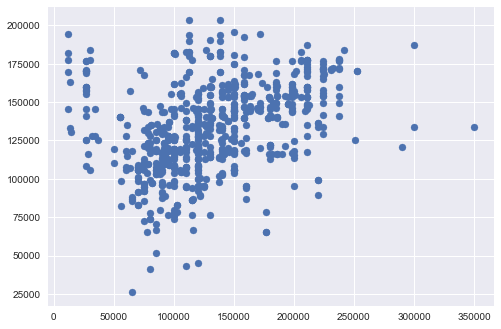

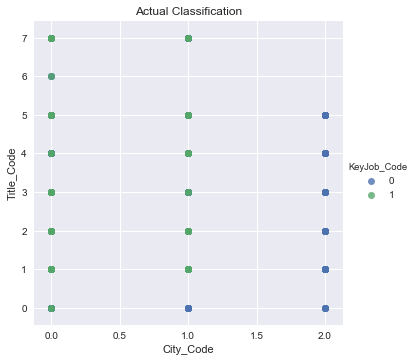

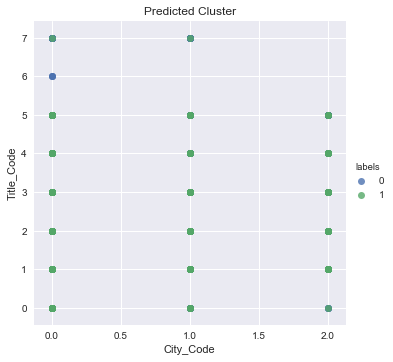

In [147]:
# Checking how the predicted value differs from the original value.
# The silhouette score is not great. But just checking it up
data_job2 = data_job
data_job2['labels'] = labels_2

sns.lmplot(x='City_Code', y='Title_Code', data=data_job2, hue='KeyJob_Code', fit_reg=False)
plt.title('Actual Classification')
plt.show()

sns.lmplot(x='City_Code', y='Title_Code', data=data_job2, hue='labels',fit_reg=False)
plt.title('Predicted Cluster')
plt.show()

#### Fit the predictors and target onto the model

In [148]:
# Create target and predictor data
X_cls = X
y_cls = y.values

In [149]:
# Cross validate logistic regression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

In [150]:
cls_scores = cross_val_score(LogisticRegression(), X_cls, y_cls, cv=8)

print ('Classification/Logistic regression score:', cls_scores, np.mean(cls_scores))

logreg = LogisticRegression().fit(X_cls, y_cls)

Classification/Logistic regression score: [ 0.88825215  0.89111748  0.91690544  0.95415473  0.97701149  0.96541787
  0.96253602  0.95100865] 0.938300478713


#### The Classification score is good. But its the whole data.  Can I. split it into test and train set

#### The aim is to find a features that contribute toidentify the different classification groups. I will try using the Grid Search CV for the  Decision tree classifier

In [151]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

In [152]:
# Setting up the parameters for Gridsearch CV
dtc_params = {
    'max_depth':[None,1,2,3,4],
    'max_features':[None,'log2','sqrt',2,3,4,5],
    'min_samples_split':[2,3,4,5,10,15,20,25,30,40,50]
}

dtc_gs = GridSearchCV(DecisionTreeClassifier(), dtc_params, cv=5, verbose=1)

In [153]:
dtc_gs.fit(X_cls, y_cls)

Fitting 5 folds for each of 385 candidates, totalling 1925 fits


[Parallel(n_jobs=1)]: Done 1925 out of 1925 | elapsed:  1.9min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'max_depth': [None, 1, 2, 3, 4], 'max_features': [None, 'log2', 'sqrt', 2, 3, 4, 5], 'min_samples_split': [2, 3, 4, 5, 10, 15, 20, 25, 30, 40, 50]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=1)

In [154]:
dtc_best = dtc_gs.best_estimator_
print (dtc_gs.best_params_)
print (dtc_gs.best_score_)

{'max_depth': 4, 'max_features': 'sqrt', 'min_samples_split': 30}
0.963016157989


In [155]:
# Get the features with the most importance from the GridSearch CV on the Decision Tree classifier
fi = pd.DataFrame({
        'feature':X_cls.columns,
        'importance':dtc_best.feature_importances_
    })

fi.sort_values('importance', ascending=False, inplace=True)
fi = fi[fi['importance'] > 0]
fi

,feature,importance
326,data scientist,0.567377
105,analytics data,0.196999
36,Adv_Code_1,0.081242
1021,written communication skills,0.035849
832,sexual orientation,0.034781
977,user experience,0.030786
258,communication skills written,0.028049
220,business value,0.013511
197,business partnering,0.011405


In [156]:
fi.feature.unique()

array(['data scientist', 'analytics data', 'Adv_Code_1',
       'written communication skills', 'sexual orientation',
       'user experience', 'communication skills written', 'business value',
       'business partnering'], dtype=object)

### It couldnt be more obvious than this! 
- The feature that makes data scientists stand out from the others is 'data scientist', 'analytics data', 'written communication skills', 'user experience', 'communication skills written', 'business value','business partnering.
- An unexpected one is 'sexual orientation', I think it is there because to explicitly say there is no discrimination! I will need to investigate further as to why it was in there!

### Qn. What features are important for distinguishing junior vs. senior positions?
- Here I will be using the Title_Code feature tthat classifies around 7 levels of positions to identify the clusters. 
- I am scoping it further by using it as multiple classification than a binary one!



In [123]:
# Copying my dataframe with the all the scraped jobs. Here it doesnt matter if there is a valid salary or not.
data_job = data

In [124]:
data_job.head()

,Title_Code,City_Code,Region_Code,Classif_Code,WorkType_Code,Adv_Code,KeyJob_Code,JobDescript,Salary
0,3,0,0,0,0,2,1,Experience with Hadoop & Spark and related clo...,0.0
1,5,0,0,0,0,0,1,I am currently looking for a Senior Manager o...,180000.0
2,7,0,0,0,0,2,1,We are looking for a Head of Data Science Mach...,0.0
3,7,0,0,0,0,2,1,A unique Career opportunity along with an exce...,0.0
4,7,0,0,1,0,2,1,Our Company Tabcorp is one of the few integrat...,0.0


In [127]:
# As a matter of fact, I could drop salary and try to figure out other 
# features that distinguish Data Scientists from other jobs.
data_job.drop('Salary', axis = 1, inplace = True)

In [242]:
# Convert the categorical variables to dummies to proceed with linear regression
data_job_dummies = pd.get_dummies(data_job, drop_first = True, columns = ['KeyJob_Code', 'City_Code', 'Region_Code', 'Classif_Code',
       'WorkType_Code', 'Adv_Code'])

In [243]:
data_job_dummies.head(2)

,Title_Code,JobDescript,labels,KeyJob_Code_1,City_Code_1,City_Code_2,Region_Code_1,Region_Code_2,Region_Code_3,Region_Code_4,Region_Code_5,Region_Code_6,Region_Code_7,Region_Code_8,Region_Code_9,Region_Code_10,Region_Code_11,Region_Code_12,Region_Code_13,Region_Code_14,Region_Code_15,Region_Code_16,Region_Code_17,Region_Code_18,Classif_Code_1,Classif_Code_2,Classif_Code_3,Classif_Code_4,Classif_Code_5,Classif_Code_6,Classif_Code_7,WorkType_Code_1,WorkType_Code_2,Adv_Code_1,Adv_Code_2
0,3,Experience with Hadoop & Spark and related clo...,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,5,I am currently looking for a Senior Manager o...,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [244]:
from sklearn.feature_extraction.text import CountVectorizer

In [245]:
# Join all the Job Titles
all_text = [text for text in data_job_dummies['JobDescript']]

# Use Count vectorizer to get the  most used names in titles
vectorizer = CountVectorizer(analyzer = "word",tokenizer = None,
                             preprocessor = None,stop_words = 'english',max_features = 1000, ngram_range = (2,3)) 

# Fit the titles to the model
train_data_features = vectorizer.fit_transform(all_text)

# Get the words and the count from the model
job_desc_words = pd.DataFrame(vectorizer.transform(all_text).todense(), columns=vectorizer.get_feature_names())

# Pick the top 40 to create the job title category
job_desc_words.sum().nlargest(1000)
job_desc_words.head()

,10 years,12 month,12 months,400 words,ability analyse,ability build,ability communicate,ability deliver,ability develop,ability engage,ability influence,ability manage,ability work,ability work independently,able demonstrate,able work,accc aer,accc aer responsibilities,accc aers,accc gov,accc gov au,accc independent,accc independent commonwealth,accc specialist legal,acceptance criteria,acceptance testing,account management,accounting related,act 2010,actionable insights,ad hoc,add value,advanced analytics,advanced excel,advanced excel skills,advice range,aer board,aer called,agile delivery,agile development,agile environment,agile experience,agile methodology,agile scrum,agile waterfall,alternatively confidential,analyse assess,analyse assess distil,analyse business,analysis business,analysis data,analysis design,analysis documentation,analysis experience,analysis reporting,analysis skills,analyst experience,analyst join,analyst join team,analyst responsible,analyst role,analyst strong,analyst work,analytical problem,analytical problem solving,analytical skills,analytical skills ability,analytics data,analytics information,analytics reporting,analytics team,application development,application support,applications close,apply button,apply button information,apply click,apply click apply,apply contact,apply directly,apply forward,apply job,apply link,apply online,apply online click,apply online using,apply position,apply role,apply send,apply today,appropriate link,areas business,asia pacific,assess distil,assess distil key,assessing reviewing mergers,asset management,asx listed,australia leading,australia new,australia new zealand,australian economy,australias largest,australias leading,award winning,awareness influence,awareness influence business,bachelor degree,bachelors degree,banking financial,based information,based melbourne,based sydney,based sydney cbd,best practice,best practices,bi analytics,bi reporting,bi tools,big data,big data analytics,body responsible,body responsible regulating,brand new,broad range,build maintain,build organisational,build organisational capability,build relationships,business acumen,business analysis,business analysis experience,business analyst,business analyst experience,business analyst join,business analyst role,business analyst strong,business analyst work,business analysts,business areas,business case,business cases,business change,business data,business decisions,business development,business environment,business functional,business improvement,business information,business intelligence,business intelligence analyst,business intelligence analytics,business intelligence data,business intelligence tools,business needs,business objectives,business operations,business outcomes,business partnering,business partners,business performance,business problems,business process,business process improvement,business process mapping,business process modelling,business processes,business related,business requirements,business requirements functional,business role,business rules,business solutions,business stakeholders,business systems,business technical,business technology,business transformation,business unit,business units,business users,business value,button information,button information opportunities,ca cpa,candidates contacted,candidates strong,capability provide,career development,career progression,case development,cbd location,change management,changes market,changes prepare,changes prepare correspondence,click apply,click apply button,clicking apply,clicking apply button,client leading,client looking,client seeking,clients business,closely business,com au,com company,commerce accounting,commerce accounting related,commercial acumen,commercial experience,commonwealth statutory,commonwealth statutory authority,communication interpersonal,communication interpersonal skills,communication skills,communication skills ability,communication skills experience,communication skills strong,communicat

In [246]:
job_desc_words.sum().nlargest(1000)

business analyst                         1514
business intelligence                     962
experience working                        894
communication skills                      864
business requirements                     680
years experience                          611
com au                                    582
skills experience                         556
business analysis                         528
business process                          472
high level                                461
skills ability                            460
problem solving                           459
ability work                              410
click apply                               404
end end                                   375
apply button                              369
data analysis                             362
project management                        361
financial services                        356
confidential discussion                   334
data analytics                    

In [247]:
print(job_desc_words.shape)
data_job_dummies.shape

(2785, 1000)


(2785, 35)

In [248]:
print(job_desc_words.shape)
data_job_dummies.shape

(2785, 1000)


(2785, 35)

In [249]:
# Create a concatenated dataframe with the Job data and the m,
data_job_dummies = pd.concat([data_job_dummies, job_desc_words], axis=1)
data_job_dummies.shape
# data_w_text.head()

(2785, 1035)

In [250]:
data_job_dummies.head()
data_job_dummies.drop('JobDescript', axis = 1, inplace = True)

In [251]:
data_job_dummies.columns

Index(['Title_Code', 'labels', 'KeyJob_Code_1', 'City_Code_1', 'City_Code_2',
       'Region_Code_1', 'Region_Code_2', 'Region_Code_3', 'Region_Code_4',
       'Region_Code_5',
       ...
       'xad xad', 'xad xad xad', 'years business', 'years business analysis',
       'years experience', 'years experience business',
       'years experience working', 'youll need', 'youll need succeed',
       'youre interested'],
      dtype='object', length=1034)

### My dataframe is ready for the model. Next what I need is a clustering/classification technique that can be used!

### Qn. Do the requirements for titles vary significantly with industry (e.g. healthcare vs. government)?
- Here I will be using the Classif_Code feature tthat classifies around 7 industry types to identify the clusters. 
- I am scoping it further by using it as multiple classification than a binary one!
- Check my data distribution and see which kind of classifier to use. DBScan could be one way to go about it

In [252]:
# Copying my dataframe with the all the scraped jobs. Here it doesnt matter if there is a valid salary or not.
data_job = data

In [253]:
data_job.head()

,Title_Code,City_Code,Region_Code,Classif_Code,WorkType_Code,Adv_Code,KeyJob_Code,JobDescript,Salary
0,3,0,0,0,0,2,1,Experience with Hadoop & Spark and related clo...,0.0
1,5,0,0,0,0,0,1,I am currently looking for a Senior Manager o...,180000.0
2,7,0,0,0,0,2,1,We are looking for a Head of Data Science Mach...,0.0
3,7,0,0,0,0,2,1,A unique Career opportunity along with an exce...,0.0
4,7,0,0,1,0,2,1,Our Company Tabcorp is one of the few integrat...,0.0


In [254]:
# As a matter of fact, I could drop salary and try to figure out other 
# features that distinguish Data Scientists from other jobs.
data_job.drop('Salary', axis = 1, inplace = True)

In [255]:
# Convert the categorical variables to dummies to proceed with linear regression
data_job_dummies = pd.get_dummies(data_job, drop_first = True, columns = ['KeyJob_Code', 'City_Code', 'Region_Code', 'Title_Code',
       'WorkType_Code', 'Adv_Code'])

In [256]:
data_job_dummies.head(2)

,Classif_Code,JobDescript,KeyJob_Code_1,KeyJob_Code_2,KeyJob_Code_3,KeyJob_Code_4,City_Code_1,City_Code_2,Region_Code_1,Region_Code_2,Region_Code_3,Region_Code_4,Region_Code_5,Region_Code_6,Region_Code_7,Region_Code_8,Region_Code_9,Region_Code_10,Region_Code_11,Region_Code_12,Region_Code_13,Region_Code_14,Region_Code_15,Region_Code_16,Region_Code_17,Region_Code_18,Title_Code_1,Title_Code_2,Title_Code_3,Title_Code_4,Title_Code_5,Title_Code_6,Title_Code_7,WorkType_Code_1,WorkType_Code_2,Adv_Code_1,Adv_Code_2
0,0,Experience with Hadoop & Spark and related clo...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1
1,0,I am currently looking for a Senior Manager o...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0


In [257]:
from sklearn.feature_extraction.text import CountVectorizer

In [258]:
# Join all the Job Titles
all_text = [text for text in data_job_dummies['JobDescript']]

# Use Count vectorizer to get the  most used names in titles
vectorizer = CountVectorizer(analyzer = "word",tokenizer = None,
                             preprocessor = None,stop_words = 'english',max_features = 1000, ngram_range = (2,3)) 

# Fit the titles to the model
train_data_features = vectorizer.fit_transform(all_text)

# Get the words and the count from the model
job_desc_words = pd.DataFrame(vectorizer.transform(all_text).todense(), columns=vectorizer.get_feature_names())

# Pick the top 40 to create the job title category
job_desc_words.sum().nlargest(1000)
job_desc_words.head()

,10 years,12 month,12 months,400 words,ability analyse,ability build,ability communicate,ability deliver,ability develop,ability engage,ability influence,ability manage,ability work,ability work independently,able demonstrate,able work,accc aer,accc aer responsibilities,accc aers,accc gov,accc gov au,accc independent,accc independent commonwealth,accc specialist legal,acceptance criteria,acceptance testing,account management,accounting related,act 2010,actionable insights,ad hoc,add value,advanced analytics,advanced excel,advanced excel skills,advice range,aer board,aer called,agile delivery,agile development,agile environment,agile experience,agile methodology,agile scrum,agile waterfall,alternatively confidential,analyse assess,analyse assess distil,analyse business,analysis business,analysis data,analysis design,analysis documentation,analysis experience,analysis reporting,analysis skills,analyst experience,analyst join,analyst join team,analyst responsible,analyst role,analyst strong,analyst work,analytical problem,analytical problem solving,analytical skills,analytical skills ability,analytics data,analytics information,analytics reporting,analytics team,application development,application support,applications close,apply button,apply button information,apply click,apply click apply,apply contact,apply directly,apply forward,apply job,apply link,apply online,apply online click,apply online using,apply position,apply role,apply send,apply today,appropriate link,areas business,asia pacific,assess distil,assess distil key,assessing reviewing mergers,asset management,asx listed,australia leading,australia new,australia new zealand,australian economy,australias largest,australias leading,award winning,awareness influence,awareness influence business,bachelor degree,bachelors degree,banking financial,based information,based melbourne,based sydney,based sydney cbd,best practice,best practices,bi analytics,bi reporting,bi tools,big data,big data analytics,body responsible,body responsible regulating,brand new,broad range,build maintain,build organisational,build organisational capability,build relationships,business acumen,business analysis,business analysis experience,business analyst,business analyst experience,business analyst join,business analyst role,business analyst strong,business analyst work,business analysts,business areas,business case,business cases,business change,business data,business decisions,business development,business environment,business functional,business improvement,business information,business intelligence,business intelligence analyst,business intelligence analytics,business intelligence data,business intelligence tools,business needs,business objectives,business operations,business outcomes,business partnering,business partners,business performance,business problems,business process,business process improvement,business process mapping,business process modelling,business processes,business related,business requirements,business requirements functional,business role,business rules,business solutions,business stakeholders,business systems,business technical,business technology,business transformation,business unit,business units,business users,business value,button information,button information opportunities,ca cpa,candidates contacted,candidates strong,capability provide,career development,career progression,case development,cbd location,change management,changes market,changes prepare,changes prepare correspondence,click apply,click apply button,clicking apply,clicking apply button,client leading,client looking,client seeking,clients business,closely business,com au,com company,commerce accounting,commerce accounting related,commercial acumen,commercial experience,commonwealth statutory,commonwealth statutory authority,communication interpersonal,communication interpersonal skills,communication skills,communication skills ability,communication skills experience,communication skills strong,communicat

In [259]:
job_desc_words.sum().nlargest(1000)

business analyst                         1514
business intelligence                     962
experience working                        894
communication skills                      864
business requirements                     680
years experience                          611
com au                                    582
skills experience                         556
business analysis                         528
business process                          472
high level                                461
skills ability                            460
problem solving                           459
ability work                              410
click apply                               404
end end                                   375
apply button                              369
data analysis                             362
project management                        361
financial services                        356
confidential discussion                   334
data analytics                    

In [260]:
print(job_desc_words.shape)
data_job_dummies.shape

(2785, 1000)


(2785, 37)

In [261]:
print(job_desc_words.shape)
data_job_dummies.shape

(2785, 1000)


(2785, 37)

In [262]:
# Create a concatenated dataframe with the Job data and the m,
data_job_dummies = pd.concat([data_job_dummies, job_desc_words], axis=1)
data_job_dummies.shape
# data_w_text.head()

(2785, 1037)

In [263]:
data_job_dummies.head()
data_job_dummies.drop('JobDescript', axis = 1, inplace = True)

In [264]:
data_job_dummies.columns

Index(['Classif_Code', 'KeyJob_Code_1', 'KeyJob_Code_2', 'KeyJob_Code_3',
       'KeyJob_Code_4', 'City_Code_1', 'City_Code_2', 'Region_Code_1',
       'Region_Code_2', 'Region_Code_3',
       ...
       'xad xad', 'xad xad xad', 'years business', 'years business analysis',
       'years experience', 'years experience business',
       'years experience working', 'youll need', 'youll need succeed',
       'youre interested'],
      dtype='object', length=1036)

### My dataframe is ready for the model. Next what I need is a clustering/classification technique that can be used!



**BONUS PROBLEM:**

Your boss would rather tell a client incorrectly that they would get a lower salary job than tell a client incorrectly that they would get a high salary job. Adjust one of your models to ease his mind, and explain what it is doing and any tradeoffs. Plot the ROC curve.

### This is to adjust the confusion matrix as per our requirement and plot ROC curve
Note that this requires framing the salary problem as a classification problem detecting low vs. high salary positions.

---


## Requirements

- Scrape and prepare your data using BeautifulSoup.

- **Create and compare at least two models for each section.**. One of the two models should be a decision tree or ensemble model. The other can be a classifier or regression of your choosing: Ridge, logistic regression, KNN, SVM, etc.
- A Jupyter Notebook with your analysis for a peer audience of data scientists. Make sure to clearly describe and label each section.
- A written report directed to your (non-technical!) Principal

 **Pro Tip:** You can find a good example report [here](https://www.dlsweb.rmit.edu.au/lsu/content/2_assessmenttasks/assess_tuts/reports_ll/report.pdf).

 **Pro Tip 2:** Scraping is one of the most fun, useful and interesting skills out there!  Don’t lose out by copying someone else.

___
### Useful Resources

- Read the docs for whatever technologies you use. Most of the time, there is a tutorial that you can follow, but not always, and learning to read documentation is crucial to your success!
- Document **everything**.
- Look up sample executive summaries online.
- [Advice on How to Write for a Non-Technical Audience](http://programmers.stackexchange.com/questions/11523/explaining-technical-things-to-non-technical-people)
- [Documentation for BeautifulSoup can be found here](http://www.crummy.com/software/BeautifulSoup/).

---

### Project Feedback + Evaluation

[See our DSI projects guide here.]()


# BELOW CODE IS JUST  TEST AND LEARNING!

In [ ]:
#### Try NLP on Job description

In [ ]:
# NLP Using a count vectorizer.  
from sklearn.feature_extraction.text import TfidfVectorizer
tvec = TfidfVectorizer(stop_words='english')

In [ ]:
text = job_posts_df.ix[1,'jd']
text

In [ ]:
stop_words = set(stopwords.words("english"))   
job_posts_df['jd_wo_stop'] = [[w for w in jd.split() if w not in stop_words]
                      for jd in job_posts_df['jd']]


In [ ]:
job_posts_df[['jd_wo_stop']].head()

In [ ]:
text = job_posts_df['jd_wo_stop']

In [ ]:
vectorizer = CountVectorizer(analyzer = "word",tokenizer = None,preprocessor = None,stop_words = 'english',max_features = 1000) 

# fit_transform() does two functions: First, it fits the model
# and learns the vocabulary; second, it transforms our training data
# into feature vectors. The input to fit_transform should be a list of 
# strings.
train_data_features = vectorizer.fit_transform(text)
print (train_data_features.shape)

In [ ]:
# Fit cvec and converting the result to a DataFrame.
words_df = pd.DataFrame(vectorizer.transform(text).todense(), columns=vectorizer.get_feature_names())

print (words_df.shape)

words_df.fillna(0)
words_df.sum()


### Try NLP?

#### Count Vectorizer -A sort of a better Bag of words model!

In [ ]:
# NLP Using a count vectorizer.  
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
cvec = CountVectorizer()

In [ ]:
spam = """
Hello,\nI saw your contact information on LinkedIn. I have carefully read through your profile and you seem to have an outstanding personality. This is one major reason why I am in contact with you. My name is Mr. Valery Grayfer Chairman of the Board of Directors of PJSC "LUKOIL". I am 86 years old and I was diagnosed with cancer 2 years ago. I will be going in for an operation later this week. I decided to WILL/Donate the sum of 8,750,000.00 Euros(Eight Million Seven Hundred And Fifty Thousand Euros Only etc. etc.
"""

ham = """
Hello,\nI am writing in regards to your application to the position of Data Scientist at Hooli X. We are pleased to inform you that you passed the first round of interviews and we would like to invite you for an on-site interview with our Senior Data Scientist Mr. John Smith. You will find attached to this message further information on date, time and location of the interview. Please let me know if I can be of any further assistance. Best Regards.
"""

In [ ]:
cvec.fit([spam])

In [ ]:
df  = pd.DataFrame(cvec.transform([spam]).todense(),
             columns=cvec.get_feature_names())


In [ ]:
df.transpose().sort_values(0, ascending=False).head(10).transpose()

#### Hashing Vectorizer - Number generated from a string of text

In [ ]:
from sklearn.feature_extraction.text import HashingVectorizer

In [ ]:
hvec = HashingVectorizer()

In [ ]:
hvec.fit([spam])

In [ ]:
df  = pd.DataFrame(hvec.transform([spam]).todense())  

df.transpose().sort_values(0, ascending=False).head(10).transpose()

#### Segmentation - Identify sentence within a body of text

In [ ]:
from nltk.tokenize import PunktSentenceTokenizer

In [ ]:
sent_detector = PunktSentenceTokenizer()

In [ ]:
easy_text = "I went to the zoo today. What do you think of that? I bet you hate it! Or maybe you don't"

In [ ]:
sent_detector.sentences_from_text(easy_text)

#### Stemming - Text normalization

In [ ]:
from nltk.stem import PorterStemmer

In [ ]:
stemmer = PorterStemmer()
print (stemmer.stem('Swimmed'))
print (stemmer.stem('Swimming'))

#### Stop words

In [ ]:
from nltk.corpus import stopwords

In [ ]:
stopwords.words('english')

#### Part of speech tagging

In [ ]:
from nltk.tag import pos_tag

In [ ]:
from nltk.tokenize import WordPunctTokenizer

In [ ]:
tok = WordPunctTokenizer()

In [ ]:
pos_tag(tok.tokenize("today is a great day to learn nlp"))

#### Term Frequency

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
tvec = TfidfVectorizer(stop_words='english')

In [ ]:
tvec.fit([spam,ham])

In [ ]:
df = pd.DataFrame((tvec.transform([spam,ham])).todense(), 
columns = tvec.get_feature_names(), index=['spam','ham'])

In [ ]:
df.transpose().sort_values('spam', ascending=False).head(10).transpose()

In [ ]:
df.transpose().sort_values('ham', ascending=False).head(10).transpose()